# Shelf Life classification of Apple using transfer learning 

### Aim: To predict the remaining shelf life of apple.

#### Theory:  How long do apple lasts? 

It depends on when it was harvested, how it has been stored since that time, and whether it has been washed, cut, or cooked.

Many fruit distributors store apples in controlled conditions that keep them fresh for several months before reaching grocery stores. For instance, apple bins are often treated with a gas called 1-methylcyclopropene (1-MCP) which  prevents apples from ripening by blocking the effects of ethylene(a colorless gas that drives the produce ripening process). However, ripening resumes once the apples are removed from these conditions.

Here are the approximate shelf lives of apples, depending on how they are prepared and stored:
**On the counter:** 5–7 days

**In the pantry:** 3 weeks

**In the refrigerator:** 4–6 weeks

**Once cut:** 3–5 days in the fridge

#### Shelf Life prediction methods:

**1. Manual:** It involves leaving items on a shelf to rot and counting the days until they reach their “end of life.” It cannot account for variation between batches and is slow to perform. 

**2. Temprature monitoring:** Temperature and humidity conditions play a large role in affecting the shelf life of produce. You can predict the shelf life of a certain batch by comparing the temperature profile to that of historical batches.

**3. Ethylene Monitoring:** Analyzing ethylene, can help you understand when products are ripening. For example, if you notice a spike in ethylene you can determine that it will probably take around eleven days for your fruit to rot. This can help you decide which batches to ship our first.

**4. Spectroscopy:** Every fruit and vegetable has a unique “spectral fingerprint.” Algorithms compare this spectral data to existing data for that variety to predict shelf life. It’s as simple as holding a device against an item for only one second as near-infrared (NIR) light enters the item.

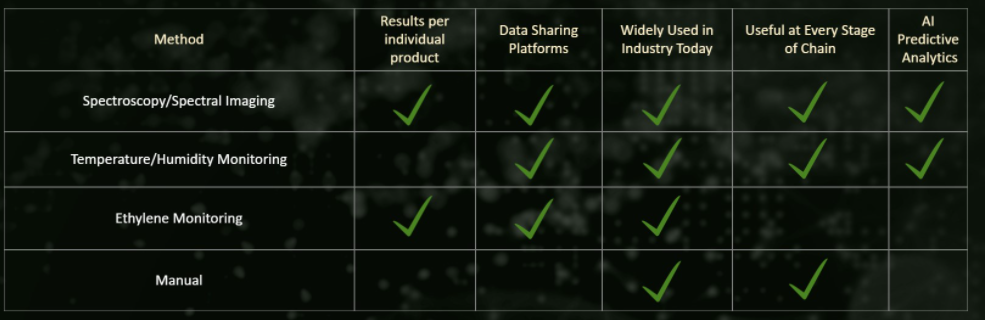

#### Problems faced for data collection:

It was difficult to find open source dataset with proper features affecting the shelf life of a fruit. The Dataset acquired is from kaggle.com which consists images of different phases of apple shelf life. The data acquired is of the form:

**1. Apple(1-5):**  Images depicting the remaining shelf life of apple is 1 to 5 days.(About to rot)

**2. Apple(5-10):** Images depicting the remaining shelf life of apple is 5-10 days.(Can be used)

**3. Apple(10-14):** Images depicting the remaining shelf life of apple is 10-14 days.(Fresh)

**4. Expired:** Images depicting the expired apples.

#### Data preprocessing: The datset is then classified into 3 sets named: 
1. train_data
2. test_data
3. validation_data

Each of them consists of four classes mentioned above. 

The train set consists of 80% data and remaining 10% is in test set and 10% in validation set.

### Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt
import cv2

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19

### 1. Loading datset from the folder

In [2]:
dataset='dataset1'

train_folder = os.path.join(dataset,"train_data")
test_folder = os.path.join(dataset,"test_data")
validation_folder = os.path.join(dataset,"val_data")

### 2. Counting the images in different directories

In [3]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

print("Train folder contents:")
count_files(os.path.join(train_folder))
print('\n')
print("Test folder contents:")
count_files(os.path.join(test_folder))
print('\n')
print("Valiadtion folder contents:")
count_files(os.path.join(validation_folder))

Train folder contents:
There are 103 files in Apple(1-5)
There are 245 files in Apple(10-14)
There are 126 files in Apple(5-10)
There are 153 files in Expired


Test folder contents:
There are 15 files in Apple(1-5)
There are 29 files in Apple(10-14)
There are 22 files in Apple(5-10)
There are 20 files in Expired


Valiadtion folder contents:
There are 15 files in Apple(1-5)
There are 29 files in Apple(10-14)
There are 22 files in Apple(5-10)
There are 20 files in Expired


### 3. Showing classes of images

Text(0.5, 1.0, 'Expired')

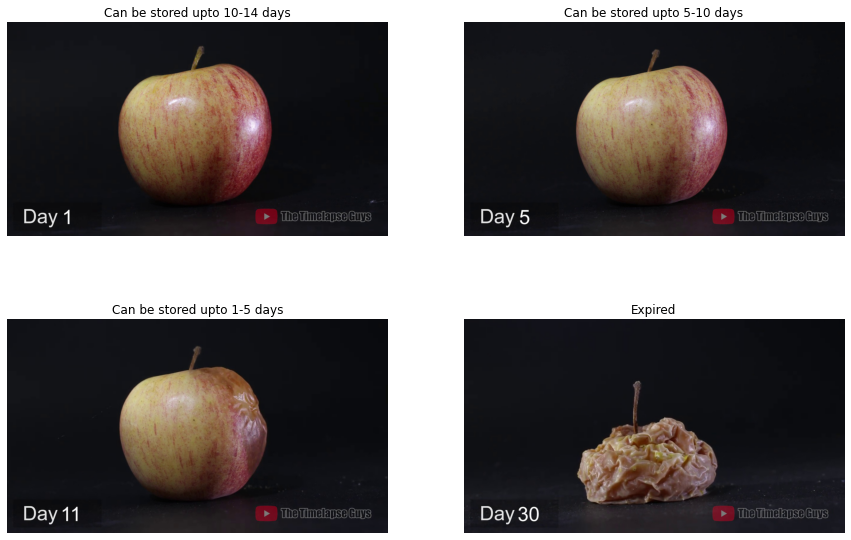

In [4]:
# create figure
fig = plt.figure(figsize=(15, 10))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
Image1 = cv2.imread('dataset1/train_data/Apple(10-14)/frame11.jpg')
Image2 = cv2.imread('dataset1/train_data/Apple(5-10)/frame154.jpg')
Image3 = cv2.imread('dataset1/train_data/Apple(1-5)/frame357.jpg')
Image4 = cv2.imread('dataset1/train_data/Expired/frame1011.jpg')

#converting to RGB
Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
Image2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
Image3 = cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB)
Image4 = cv2.cvtColor(Image4, cv2.COLOR_BGR2RGB)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Can be stored upto 10-14 days")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Can be stored upto 5-10 days")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Can be stored upto 1-5 days")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Expired")

### 4. Model Building

In [5]:
IMAGE_SIZE = [300, 300]

from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.25)(x)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#### 4.1 Training the model

In [6]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (300, 300),
    batch_size = 32,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (300, 300),
    batch_size = 32, 
    class_mode = 'categorical')

Found 627 images belonging to 4 classes.
Found 86 images belonging to 4 classes.


In [7]:
class_map = training_set.class_indices
class_map

{'Apple(1-5)': 0, 'Apple(10-14)': 1, 'Apple(5-10)': 2, 'Expired': 3}

#### 4.2 Fitting the Model

In [8]:
r = model.fit_generator(
  training_set,
  validation_data = test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 70s 4s/step - loss: 0.9691 - accuracy: 0.5997 - val_loss: 0.7807 - val_accuracy: 0.6047
Epoch 2/10
20/20 [==============================] - 67s 3s/step - loss: 0.6562 - accuracy: 0.7161 - val_loss: 0.6062 - val_accuracy: 0.6977
Epoch 3/10
20/20 [==============================] - 66s 3s/step - loss: 0.5237 - accuracy: 0.7783 - val_loss: 0.5395 - val_accuracy: 0.7093
Epoch 4/10
20/20 [==============================] - 74s 4s/step - loss: 0.4712 - accuracy: 0.7879 - val_loss: 0.5074 - val_accuracy: 0.7442
Epoch 5/10
20/20 [==============================] - 78s 4s/step - loss: 0.4490 - accuracy: 0.8102 - val_loss: 0.3930 - val_accuracy: 0.8837
Epoch 6/10
20/20 [==============================] - 78s 4s/step - loss: 0.4129 - accuracy: 0.8293 - val_loss: 0.3907 - val_accuracy: 0.8721
Epoch 7/10
20/20 [==============================] - 60s 3s/step - loss: 0.3612 - acc

#### 4.3 Saving the Model

In [9]:
model.save('model_inceptionV3_epoch10.h5')

### 5. Plotting Accuracy and Loss Curves

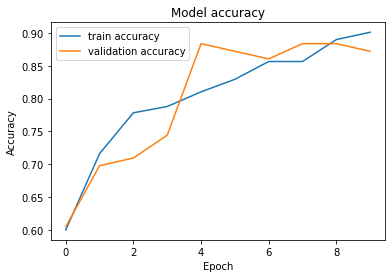

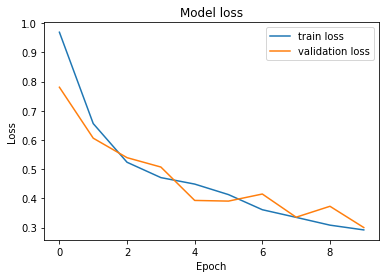

In [10]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

### 6. Predictions

#### 6.1 Loading the model 

In [11]:
import tensorflow.keras.backend as K

K.clear_session()
path_to_model='./model_inceptionV3_epoch10.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


#### 6.2 Testing the model on validation set

In [12]:
validation_data_dir = 'dataset1/val_data'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(300,300),
    batch_size= 32,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 86 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Accuracy: 0.884


#### 6.3 Functions to predict the output of the model

In [13]:
category={  1 : "Apple(1-5)", 2 :"Apple(10-14)" , 3 : "Apple(5-10)", 4 : "Expired"}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(300, 300))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = (np.argmax(prediction)+1)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('\\')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(300, 300))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index1 = (np.argmax(prediction)+1)
        
        pred = category.get(index1)
        if pred == true:
            pos=pos+1
     
    acc = pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

#### 6.4 Making Prediction on single image

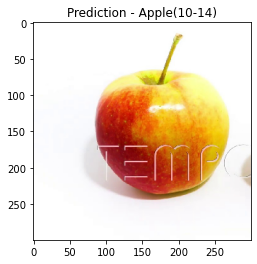

In [14]:
#single image prediction
predict_image(os.path.join(validation_folder,'Apple(10-14)/frame10.jpg'),model)

#### 6.5 Making prediction on validation set and calculating accuracies

In [15]:
#Validation directory accuracy predict
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

Accuracy for Apple(1-5): 0.87 (13/15)
Accuracy for Apple(10-14): 0.86 (25/29)
Accuracy for Apple(5-10): 0.82 (18/22)
Accuracy for Expired: 1.00 (20/20)


### 7. Evaluation of model using confusion matrix 

In [16]:
import seaborn as sns
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('\\')[-1]
        true=mapping[true]
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(300,300))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 4
    cmap="turbo"
    cm_plot_labels = [i for i in range(4)]
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (8,8))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()


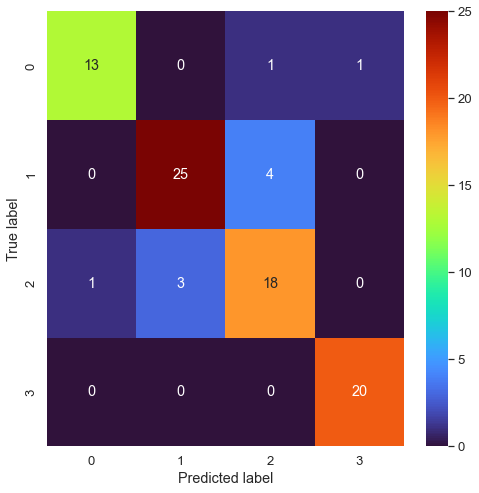

In [17]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

**Conclusions:** As seen from the above plot, the false positives are really low as we have used transfer learning which has given us good accuracy of 88%